In [78]:
# import torch
# num_of_gpus = torch.cuda.device_count()
# print(num_of_gpus)

In [79]:
# import torch

# device = torch.device("cuda:0")
# device_properties = torch.cuda.get_device_properties(device)

# print(f"Total memory available: {device_properties.total_memory / 1024**2:.2f} MB")

In [80]:
# # initialize a tensor on the GPU
# x = torch.randn(1000, 1000).cuda()

# # measure the amount of memory used by the tensor
# memory_used = torch.cuda.max_memory_allocated() / 1024**2  # convert to MB

# print(f"Memory used: {memory_used:.2f} MB")

In [81]:
# !pip install transformers
# !pip install datasets
# !pip install umap-learn
# !pip install sentencepiece

In [82]:
import torch
print(torch.cuda.is_available())

True


In [83]:
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from transformers import AutoTokenizer, AutoConfig
from transformers import AutoModel
from torch import torch
import pandas as pd
import matplotlib.pyplot as plt

from datasets import Dataset, DatasetDict
from datasets import ClassLabel, concatenate_datasets
from datasets import Dataset, ClassLabel, Features, Value
from sklearn.model_selection import train_test_split

import datasets
import pandas as pd

# para construir gráficas y realizar análisis exploratorio de los datos
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px

# para cargar datos y realizar pre-procesamiento básico
from collections import Counter

# Cargamos esta librería para revisar el desbalance que existe en el dataset de tripadvisor
from imblearn.under_sampling import RandomUnderSampler

In [84]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# CARGANDO DATOS DESDE DIFERENTES ORIGENES DE DATOS
Aquí cargamos datos de diferentes lugare
1. CARDIFF-TWEETS: Cargamos tweets desde la base de datos de cardiff: https://huggingface.co/datasets/cardiffnlp/tweet_sentiment_multilingual
2. DA-VINCIS-2022: Cargamos los datos del concurso del 2022. 
3. DA-VINCIS-2023: Cargamos los datos del concurso del 2023.

In [85]:
TEXT_COL      = 'text'
CLASS_COL_ST1 = 'label'
IMAGES        = 'images'

## CARDIFF-TWEETS
Datos del dataset de Cardiff Multilingual Tweets, de este dataset solo se extrajeron los tweets en español.

In [86]:
# extended_df = load_dataset("cardiffnlp/tweet_sentiment_multilingual", 'spanish')
# descomente la siguiente línea para leer datos desde un URL

extended_train_path = 'https://raw.githubusercontent.com/carlossuazo/davincis-iberlef-2023/main/data/cardiff-tweets-db/extended_train.csv'#'data/extended/extended_train.csv'
extended_validation_path = 'https://raw.githubusercontent.com/carlossuazo/davincis-iberlef-2023/main/data/cardiff-tweets-db/extended_validation.csv'#'data/extended/extended_validation.csv'
extended_test_path = 'https://raw.githubusercontent.com/carlossuazo/davincis-iberlef-2023/main/data/cardiff-tweets-db/extended_test.csv'#'data/extended/extended_test.csv'

# Reading the data
df_extended_train = pd.read_csv(extended_train_path)
df_extended_validation = pd.read_csv(extended_validation_path)
df_extended_test = pd.read_csv(extended_test_path)


display(df_extended_train.shape)
display(df_extended_validation.shape)
display(df_extended_test.shape)

(1839, 2)

(324, 2)

(870, 2)

In [87]:
df_extended_train["label"] = df_extended_train["label"].apply(lambda x: 1 if x == 0 else 0)
df_extended_validation["label"] = df_extended_validation["label"].apply(lambda x: 1 if x == 0 else 0)
df_extended_test["label"] = df_extended_test["label"].apply(lambda x: 1 if x == 0 else 0)

In [88]:
# display(df_extended_train[:12])
# display(df_extended_validation[:12])
# display(df_extended_test[:12])

In [89]:
df_extended = pd.concat([df_extended_train, df_extended_validation, df_extended_test])

### Undersampling de Dataset 
Debido a que la base de datos de Cardiff está etiquetada para hacer análisis de sentimiento obre tres clases [Neutral, Positivo, Negativo], el dataset los hemos nivelado para que neutral y positivo sean una sola clase, por lo que nos queda una dataset desnivelado.

In [90]:
# obtener algunas estadísticas sobre los datos
categories = sorted(df_extended[CLASS_COL_ST1].unique(), reverse=False)
hist= Counter(df_extended[CLASS_COL_ST1]) 
print(f'Total de instancias -> {df_extended.shape[0]}')
print(f'Distribución de clases -> {{item[0]:round(item[1]/len(df_extended[CLASS_COL_ST1]), 3) for item in sorted(hist.items(), key=lambda x: x[0])}}')

print(f'Categorías -> {categories}')
print(f'Comentario de ejemplo -> {df_extended[TEXT_COL][0]}')
print(f'Categoría del comentario -> {df_extended[CLASS_COL_ST1][0]}')

fig = go.Figure(layout=go.Layout(height=400, width=600))
fig.add_trace(go.Bar(x=categories, y=[hist[cat] for cat in categories]))
fig.show()

print('Done!')

Total de instancias -> 3033
Distribución de clases -> {item[0]:round(item[1]/len(df_extended[CLASS_COL_ST1]), 3) for item in sorted(hist.items(), key=lambda x: x[0])}
Categorías -> [0, 1]
Comentario de ejemplo -> 0    estoy hasta el ojete de que me digáis que teng...
0    @user La prensa cada vez más desacreditada  De...
0    @user jajajaja dale, hacete la boluda vos jaja...
Name: text, dtype: object
Categoría del comentario -> 0    1
0    1
0    1
Name: label, dtype: int64


Done!


In [91]:
print(df_extended.head())

X = df_extended.drop('label', axis=1)
y = df_extended['label']
# resumen de las clases para ver como se encuentran distribuidas
print(Counter(y))
# definimos las estrategia de undersampling, en nuestro caso buscamos que todas
# clases se nivelen a la clase minoritaria.
undersample = RandomUnderSampler(sampling_strategy='not minority', random_state = 0)
# hacemos el fit de nuestro conjunto de datos a nivelar
X_over, y_over = undersample.fit_resample(X, y)
print(Counter(y_over))

df_extended = pd.concat([X_over, y_over], axis=1)
print(df_extended.head())

                                                text  label
0  estoy hasta el ojete de que me digáis que teng...      1
1  @user Por?  Tenía pensado verla después de la ...      0
2                           Esto de estar feliz mola      0
3                             Ya no es tan divertido      1
4  @user te recuerdo que soy una persona que tien...      0
Counter({0: 2022, 1: 1011})
Counter({0: 1011, 1: 1011})
                                                text  label
0  @user @user me dejo congelado. Por algo es el ...      0
1  @user Pues muchas gracias, nuestras puertas es...      0
2  Fin de directo! Gracias a todos los que habéis...      0
3  @user Gracias primito, le haré presente los sa...      0
4  Manuel Carrasc  -Uno x Uno me gusta  -Vale -Ok...      0


In [92]:
df_extended_train, df_extended_test = train_test_split(df_extended, test_size=0.15)
df_extended_train, df_extended_validation = train_test_split(df_extended_train, test_size=0.15)

In [93]:
df_extended_train.shape, df_extended_test.shape, df_extended_validation.shape 

((1460, 2), (304, 2), (258, 2))

In [94]:
# for split, data in extended_df.items():
#     data.to_csv(f"/extended_{split}.csv")

In [95]:
# display(extended_df)
# display(extended_df['train'].features)

In [96]:
# extended_df['train'].features

In [97]:
# # Create a ClassLabel object
# class_label = ClassLabel(names=['no', 'yes'])

# # Convert a class name to a class index
# class_index = class_label.str2int('yes')
# print(class_index) # 1

# # Convert a class index to a class name
# class_name = class_label.int2str(0)
# print(class_name) # 'no'

In [98]:

# # Define a function that takes in a row and returns the updated row
# def update_row(example):
#     # Get the class name for the current class index
#     class_name = extended_df['train'].features['label'].int2str(example['label'])
    
#     # Convert the class name to the new class index
#     new_class_index = class_label.str2int(class_name)
    
#     # Update the value of the class label column
#     example['label'] = new_class_index
#     return example

# # Update the dataset using the update_row function
# updated_dataset = extended_df.map(update_row)

# # Update the dataset's features to use the new ClassLabel object
# updated_features = updated_dataset.features.copy()
# updated_features['label'] = class_label
# updated_dataset = Dataset.from_dict(updated_dataset.to_dict(), features=updated_features)

## DA-VINCIS DATA 2022
Obtenemos los datos del concurso 2022

In [99]:
train_url_22 = 'https://raw.githubusercontent.com/carlossuazo/davincis-iberlef-2023/main/data/data-davincis-2022/training_data/train.csv'
test_url_22 = 'https://raw.githubusercontent.com/carlossuazo/davincis-iberlef-2023/main/data/data-davincis-2022/test_data/test.csv'

# Dataset de entrenamiento
df_train_22 = pd.read_csv(train_url_22, header=None, names = [TEXT_COL, CLASS_COL_ST1])

# Dataset de test
df_test_22  = pd.read_csv(test_url_22, header=None, names = [TEXT_COL, CLASS_COL_ST1])

display(df_train_22)
display(df_test_22)

,text,label
0,#Ahora | Reportan accidente de tránsito en el ...,1
1,#PrecauciónVial en #CDMX se registra cierre pa...,0
2,#traficogt 🚨🚨👉 http 3. Se realizan trabajos ...,0
3,#HoyMismo #Internacionales | El Gobierno de J...,0
4,"Casos como el accidente en Villa Lorena, en el...",0
...,...,...
3357,"Bomberos atendieron accidente vehicular, vía h...",1
3358,El @user y @user recuerdan al escritor Eraclio...,0
3359,Recientemente lo dejaron libre bajo fianza y a...,1
3360,Accidente en Calle 127 &gt; Oriente #traficobo...,0


,text,label
0,Accidente en el Vallado frente al polideportiv...,1
1,Vitor Belfort abruma a Evander Holyfield en la...,0
2,"En México, las estadísticas de violencia homic...",0
3,"Como Jorge Armando Ayala Guarín de 25 años, f...",1
4,Quebrar un vidrio ///// Quebrar el país a plom...,0
5,"#EsNoticia 📌 En aparente estado de embriaguez,...",1
6,@user Por último ponga la queja en CNN en espa...,0
7,174 aniversario de la Gesta Heroica de los Niñ...,0
8,SigAlert en Lake Elsinore. En la I-15 norte ce...,0
9,LO ÚLTIMO Al menos dos personas resultaron her...,1


In [100]:
df_22 = pd.concat([df_train_22, df_test_22])
display(df_22[:12])

,text,label
0,#Ahora | Reportan accidente de tránsito en el ...,1
1,#PrecauciónVial en #CDMX se registra cierre pa...,0
2,#traficogt 🚨🚨👉 http 3. Se realizan trabajos ...,0
3,#HoyMismo #Internacionales | El Gobierno de J...,0
4,"Casos como el accidente en Villa Lorena, en el...",0
5,Patrullero muere en accidente en la circunvala...,1
6,Todos ahora mismo busquen 'florida man' seguid...,0
7,"Breaking, primera imagen de Hamilton luego de ...",0
8,#Alerta #Seguridad ⚠️ imágenes en las que un ...,1
9,🅾️ Se registra accidente de tránsito en la Vía...,1


In [101]:
df_train_22, df_test_22 = train_test_split(df_22, test_size=0.15, stratify = df_22[CLASS_COL_ST1])
df_train_22, df_validation_22 = train_test_split(df_train_22, test_size=0.15, stratify = df_train_22[CLASS_COL_ST1])

In [102]:
df_train_22.shape, df_test_22.shape, df_validation_22.shape 

((2465, 2), (512, 2), (435, 2))

## DA-VINCIS DATA 2023

In [103]:
train_url_23 = 'https://raw.githubusercontent.com/carlossuazo/davincis-iberlef-2023/main/data/data-davincis-2023/development_data_davincis23/train_data.csv'
train_labels_url_23 = 'https://raw.githubusercontent.com/carlossuazo/davincis-iberlef-2023/main/data/data-davincis-2023/development_data_davincis23/train_labels_subtask_1.csv'

test_url_23 = 'https://raw.githubusercontent.com/carlossuazo/davincis-iberlef-2023/main/data/data-davincis-2023/test_data/test_data.csv'
validation_url_23 = 'https://raw.githubusercontent.com/carlossuazo/davincis-iberlef-2023/main/data/data-davincis-2023/development_data_davincis23/validation_data.csv'

# Dataset de entrenamiento
df_train_23 = pd.read_csv(train_url_23, header=None, names = [IMAGES,TEXT_COL], encoding = 'latin-1')
df_train_labels_23 = pd.read_csv(train_labels_url_23, header=None, names = [CLASS_COL_ST1])

# Dataset de test
_df_test__23 = pd.read_csv(test_url_23, header=None, names = [IMAGES,TEXT_COL], encoding = 'latin-1')
_df_validation__23 = pd.read_csv(validation_url_23, header=None, names = [IMAGES,TEXT_COL], encoding = 'latin-1')

df_train_23 = df_train_23.drop('images', axis=1)

# Estos son los conjuntos de entrenamiento y validación que necesitamos para validar el conjunto de datos de entrenamiento
# que se subiran a la competencia
_df_test__23 = _df_test__23.drop('images', axis=1)
_df_validation__23 = _df_validation__23.drop('images', axis=1)

display(df_train_23[:12])
display(_df_test__23[:12])
display(df_train_labels_23[:12])
display(_df_validation__23[:12])

,text
0,Morales: #EEUU ?sufrió una derrota vergonzosa?...
1,"Tus acciones te hacen ser una bella persona, n..."
2,#Seguridad ???? Detuvo polic¡a municipal a dos...
3,20 a¤os del accidente que convirtió a Alex Zan...
4,­Llega el castigo para Max Verstappen! El nee...
5,Accidente se @traficogt en el paso a desnivel...
6,#EnDesarrollo | Un camión que transportaba jug...
7,Sujeto de la izq. Aprehendido hace 2 semanas p...
8,Mi caracol al enterarse de que por accidente l...
9,Primera foto el 'Chapo Guzmán' en una cárcel d...


,text
0,En el sector Los Hongos de Tunja se present¢ u...
1,#Tr ficoSv | Reportan un accidente de tr nsito...
2,#13Sep #Lara Veh¡culo impacta contra una tuber...
3,@PNCSV confirma Accidente de tr nsito en carr...
4,Unidades del BCBVP atendieron emergencia por a...
5,?No existen reportes de violencia domstica o ...
6,Unidad Especializada en Combate al Secuestro (...
7,Aparatoso accidente deja cuatro muertos en #P ...
8,Martin Luther King Jr. fue un ministro y activ...
9,Caminar a la orilla de la carretera le cost¢ l...


,label
0,0
1,0
2,1
3,0
4,0
5,1
6,1
7,1
8,0
9,0


,text
0,Accidente en Transversal 93 #traficobogota. Tr...
1,#Entrate #Mxico / #Precauci¢nVial en #Tlaxca...
2,#Tecom n es el municipio con mayor incidencia ...
3,Asesinato del abogado Enrique Pacheco afuera d...
4,#EducacionQR: Existen muchos mitos y realidade...
5,La @PoliciaBquilla empez¢ a darle apoyo a los ...
6,Aparatoso accidente esta madrugada sobre el ki...
7,??El ciclo de la violencia es una herramienta ...
8,®El suicidio debe ser considerado un problema ...
9,@DILISACLA Me gusta imaginar que te robo una s...


In [104]:
# s = "Price: ¢50"
# s_decoded = s.encode('utf-8')
# print(s_decoded)

In [105]:
df_train_23[CLASS_COL_ST1] = df_train_labels_23[CLASS_COL_ST1]
print(df_train_23[:12])
df_23 = df_train_23

                                                 text  label
0   Morales: #EEUU ?sufrió una derrota vergonzosa?...      0
1   Tus acciones te hacen ser una bella persona, n...      0
2   #Seguridad ???? Detuvo polic¡a municipal a dos...      1
3   20 a¤os del accidente que convirtió a Alex Zan...      0
4   ­Llega el castigo para Max Verstappen!  El nee...      0
5   Accidente  se @traficogt en el paso a desnivel...      1
6   #EnDesarrollo | Un camión que transportaba jug...      1
7   Sujeto de la izq. Aprehendido hace 2 semanas p...      1
8   Mi caracol al enterarse de que por accidente l...      0
9   Primera foto el 'Chapo Guzmán' en una cárcel d...      0
10  #PrecauciónVial en #Zacatecas se registra acci...      1
11  Accidente en Bogotá-Mosquera / RN50-08A &gt;Or...      1


In [106]:
df_train_23, df_test_23 = train_test_split(df_23, test_size=0.15, stratify = df_23[CLASS_COL_ST1])
df_train_23, df_validation_23 = train_test_split(df_train_23, test_size=0.15, stratify = df_train_23[CLASS_COL_ST1])

In [107]:
df_train_23.shape, df_test_23.shape, df_validation_23.shape 

((2164, 2), (450, 2), (382, 2))

In [108]:
df_train = pd.concat([df_train_23, df_train_22, df_extended_train], ignore_index=True)
df_validation = pd.concat([df_validation_23, df_validation_22, df_extended_validation], ignore_index=True)
df_test = pd.concat([df_test_23, df_test_22, df_extended_test], ignore_index=True)

df_train[TEXT_COL] = df_train[TEXT_COL].apply(preprocess)
df_validation[TEXT_COL] = df_validation[TEXT_COL].apply(preprocess)
df_test[TEXT_COL] = df_test[TEXT_COL].apply(preprocess)

In [109]:
display(df_train[:12])
display(df_validation[:12])
display(df_test[:12])

,text,label
0,.@nexnoticias Este miércoles continuará el jui...,0
1,"Riohacha | A través de un evento, la Alcaldía ...",0
2,"??EN VIVO #ExpedienteAbierto ?? ? Mitzy, la #h...",0
3,Desde la Personería Distrital ofrecemos condol...,0
4,"Bajo persecución, asegura @user a individuo tr...",1
5,Vuelven a aplazar la audiencia contra conducto...,0
6,@user En 3 años de gobierno la 4T inundó de mu...,0
7,Sufre accidente automovilístico @user http ...,1
8,#VIDEO Pasajeros se resisten a asalto y bajan...,1
9,#ELBRAVO #Noticias #Internacional Policía del ...,0


,text,label
0,'Mi conciencia está tranquila xq fue un accide...,0
1,El trabajo en equipo entre sociedad y gobierno...,0
2,Accidente de tránsito en Guatemala ?? Peatón ...,1
3,BUSCAN A DOS HINCHAS DE LAS µGUILAS POR ASESIN...,1
4,LOS CAPTURAMOS?? ???????En #Chimborazo aprehe...,1
5,Boxeador mata a golpes a su mujer embarazada e...,1
6,"Quillao por mención en casos narcotráfico, sen...",0
7,CubaLos jóvenes artistas y escritores tienen l...,0
8,Una herida tras accidente múltiple de 13 vehíc...,1
9,­EL PRIMER 1-2 DE LA TEMPORADA! ?? McLaren tu...,0


,text,label
0,Pero el heteropatriarcado... Curioso que desd...,0
1,IDENTIFICAN A LAS 6 PERSONAS QUE FALLECIERON E...,1
2,Elementos que integran la Estrategia de Seguri...,0
3,Aún no identifican a la persona sin vida en el...,0
4,"Un accidente en la carretera CA-15, en Santa C...",1
5,Otro lamentable hecho de suicidio en una joven...,0
6,"Durante su intervención, el secretario @user c...",0
7,JoÆo Félix gana el primer asalto http http,0
8,#ATENCION Se presenta fatal accidente entre ...,1
9,éLTIMO MINUTO #CALI Hace pocos minutos se regi...,1


In [110]:
df_train.shape, df_test.shape, df_validation.shape 

((6089, 2), (1266, 2), (1075, 2))

In [111]:
df_train = df_train.reset_index(drop=True)
df_validation = df_validation.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [112]:
# Display the original column names
print("Original column names:")
print(df_train.columns)

# Display the original column names
print("Original column names:")
print(df_test.columns)

# Display the original column names
print("Original column names:")
print(df_validation.columns)


Original column names:
Index(['text', 'label'], dtype='object')
Original column names:
Index(['text', 'label'], dtype='object')
Original column names:
Index(['text', 'label'], dtype='object')


In [113]:
df = DatasetDict({
    "train": Dataset.from_pandas(df_train, features=Features({'text': Value('string'),'label': ClassLabel(names=['no_harmfull', 'harmfull'])})),
    "test": Dataset.from_pandas(df_test, features=Features({'text': Value('string'),'label': ClassLabel(names=['no_harmfull', 'harmfull'])})),
    "validation": Dataset.from_pandas(df_validation, features=Features({'text': Value('string'),'label': ClassLabel(names=['no_harmfull', 'harmfull'])}))
    })

In [114]:
df['train'].features


{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['no_harmfull', 'harmfull'], id=None)}

In [115]:
display(df['train'][15:20])

{'text': ['Autoridades de emergencias atienden accidente de bus en Coclesito. Bus de una empresa minera se vuelca. Más de 10 heridos fueron y están siendo trasladados al centro médico más cercano. #RadioPanama #Panama  http',
  '???????Nuestra personera @user participó en la jornada de promoción de salud mental y prevención del suicidio.  http',
  'Un joven murió presuntamente apuñalado por su amigo, cuando ambos convivían en El Vergel. Sobre estos hechos se abrió carpeta de investigación con número 5287/2021 por el delito de homicidio doloso.  #VEAInforma #Apuñalado #Muerto #ElVergel #Veracruz #Comparte  http',
  '#Fórmula1 El halo fue un factor determinante en el accidente de Hamilton y Verstappen   http  http',
  'Nuevo Accidente, carril derecho bloqueado en #Irving en 114 (al este del aeropuerto DFW) EB acercándose a Spur 482, deténgase y regrese el tráfico a Lp 12 Walton Walker  http'],
 'label': [1, 0, 1, 0, 1]}

In [116]:
df

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6089
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1266
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1075
    })
})

In [117]:
df['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['no_harmfull', 'harmfull'], id=None)}

In [118]:
model_ckpt = f'cardiffnlp/xlm-roberta-base-tweet-sentiment-es'#'cardiffnlp/twitter-xlm-roberta-base-sentiment'#"distilbert-base-uncased-finetuned-sst-2-english" #"cardiffnlp/twitter-roberta-base-sentiment"#"cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [119]:
text = 'Tokenizar el texto es una tarea central del NLP.'
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [0, 717, 1098, 14821, 88, 18946, 198, 220, 6, 66636, 9879, 146, 541, 37352, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [120]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['<s>', '▁To', 'ken', 'izar', '▁el', '▁texto', '▁es', '▁una', '▁', 'tarea', '▁central', '▁del', '▁N', 'LP', '.', '</s>']


In [121]:
print(tokenizer.convert_tokens_to_string(tokens))

<s> Tokenizar el texto es una tarea central del NLP.</s>


In [122]:
tokenizer.vocab_size

250002

In [123]:
tokenizer.model_max_length

512

In [124]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [125]:
def tokenize(batch):
    return tokenizer(batch[TEXT_COL], padding=True, truncation=True)

In [126]:
print(tokenize(df["train"][:2]))

{'input_ids': [[0, 6, 5, 981, 86, 425, 157, 37434, 162, 3224, 121799, 9454, 1680, 88, 177025, 2304, 51, 21089, 3922, 227461, 133201, 146, 1096, 225987, 8, 21, 452, 2733, 8, 47870, 4, 618, 1888, 1500, 29642, 71, 4, 32332, 7755, 183868, 85, 22, 64070, 8, 505, 22, 21, 43185, 91312, 146, 27123, 146590, 1342, 4471, 22346, 5, 1621, 2], [0, 12163, 528, 1436, 6, 58745, 62, 6536, 8, 51, 15058, 4, 21, 884, 6827, 54737, 158, 109005, 849, 88, 37556, 36896, 8, 21, 74717, 33, 1150, 146, 1832, 2624, 5670, 5, 54642, 1005, 22, 1621, 1621, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


In [127]:
tweets_encoded = df.map(tokenize, batched=True, batch_size=None) #batch_size=None

Map:   0%|          | 0/6089 [00:00<?, ? examples/s]

Map:   0%|          | 0/1266 [00:00<?, ? examples/s]

Map:   0%|          | 0/1075 [00:00<?, ? examples/s]

In [128]:
# al aplicar map se agregan dos nuevas columnas al objeto, 
print(tweets_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


In [129]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [130]:
if device.type == "cuda":
    print("Device is a GPU")
else:
    print("Device is a CPU")

Device is a GPU


In [131]:
#from transformers import TFAutoModel

#tf_model = TFAutoModel.from_pretrained(model_ckpt)

In [132]:
#tf_xlmr = TFAutoModel.from_pretrained("xlm-roberta-base")

In [133]:
#tf_xlmr = TFAutoModel.from_pretrained("xlm-roberta-base", from_pt=True)

In [134]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [135]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.1027,  1.0358, -0.0296,  ...,  0.1036,  0.6576,  0.3023],
         [-0.1388,  0.5491,  0.0439,  ...,  0.6479,  0.2035,  0.3543],
         [-0.1671,  0.6245,  0.1115,  ...,  0.9230,  0.2248,  0.5890],
         [-0.2122,  0.6268,  0.1407,  ...,  0.7137,  0.2024,  0.9465],
         [-0.1345,  0.3950,  0.1052,  ...,  0.5261,  0.1087,  0.1414],
         [-0.1698,  1.0364, -0.3579,  ..., -0.3886,  0.2587,  0.4952]]],
       device='cuda:0'), pooler_output=tensor([[-1.9464e-01,  4.8157e-01, -2.7178e-01, -2.8733e-02, -3.1196e-01,
          5.8256e-01,  4.8899e-01,  2.7767e-01, -4.6488e-01,  7.2372e-02,
         -2.9510e-01, -2.3338e-01,  6.3917e-01,  1.3953e-01, -4.1472e-01,
         -3.5736e-01,  7.8394e-01, -4.3117e-01, -2.8944e-01, -5.5729e-01,
          4.1489e-01,  6.4087e-02,  4.6507e-01,  6.6460e-01,  5.5806e-01,
         -6.8863e-01, -1.4213e-01, -2.5185e-01,  9.0455e-02,  2.1246e-01,
         -4.1046e-01,  1.9

In [136]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [137]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [138]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [139]:
tweets_encoded.set_format("torch",  columns=["input_ids", "attention_mask", CLASS_COL_ST1])

In [140]:
tweets_hidden = tweets_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/6089 [00:00<?, ? examples/s]

RuntimeError: CUDA out of memory. Tried to allocate 406.00 MiB (GPU 0; 8.00 GiB total capacity; 6.78 GiB already allocated; 0 bytes free; 7.02 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
def label_int2str(row):
    return df["train"].features[CLASS_COL_ST1].int2str(row)

In [ ]:
tweets_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [ ]:
import numpy as np

X_train = np.array(tweets_hidden["train"]["hidden_state"])
y_train = np.array(tweets_hidden["train"][CLASS_COL_ST1])

X_test = np.array(tweets_hidden["test"]["hidden_state"])
y_test = np.array(tweets_hidden["test"][CLASS_COL_ST1])

X_val = np.array(tweets_hidden["validation"]["hidden_state"])
y_val = np.array(tweets_hidden["validation"][CLASS_COL_ST1])

X_train.shape, X_test.shape, X_val.shape

((6089, 768), (1266, 768), (1075, 768))

In [ ]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb[CLASS_COL_ST1] = y_train
df_emb.head()

,X,Y,label
0,8.358377,8.159674,0
1,0.506419,9.200042,1
2,-1.231526,8.702053,1
3,2.897944,7.413258,1
4,-1.192715,11.703784,0


In [ ]:
df['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['no_harmfull', 'harmfull'], id=None)}

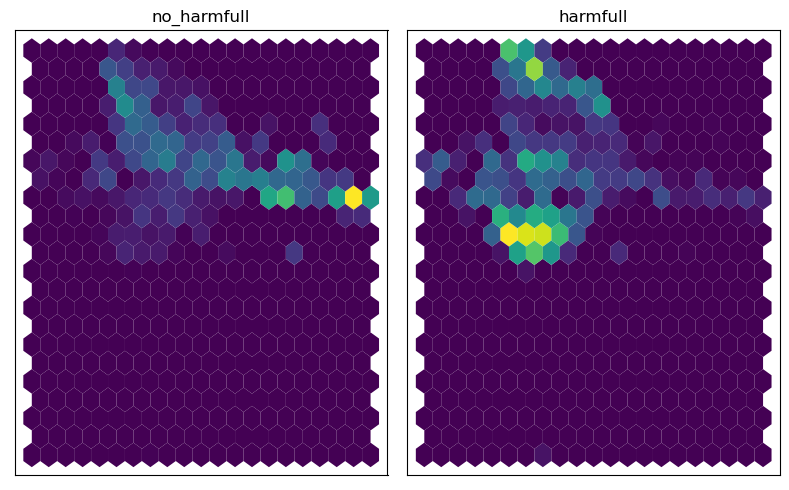

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = df["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"],# cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=100000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_val, y_val)

0.8186046511627907

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_val, y_val)

0.5209302325581395

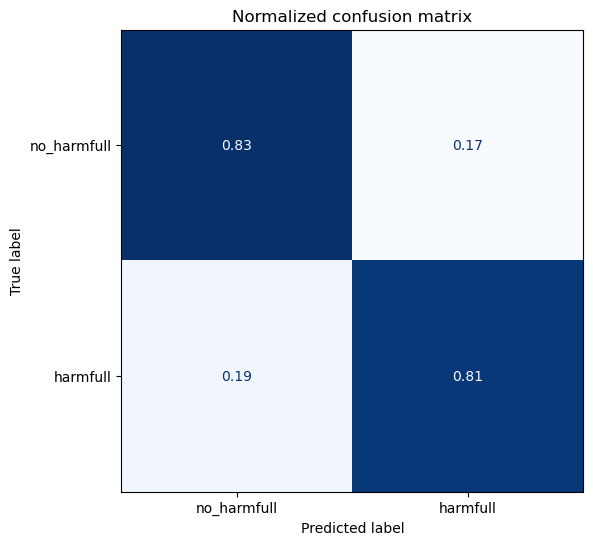

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_val)
plot_confusion_matrix(y_preds, y_val, labels)

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 2
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels, ignore_mismatched_sizes=True)
         .to(device))

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/xlm-roberta-base-tweet-sentiment-es and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [75]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to C:\Users\OWNER\.huggingface\token


In [142]:
from transformers import Trainer, TrainingArguments

batch_size = 8
logging_steps = len(tweets_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-local"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [143]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=tweets_encoded["train"],
                  eval_dataset=tweets_encoded["test"],
                  tokenizer=tokenizer)
trainer.train();

Cloning https://huggingface.co/csuazob/xlm-roberta-base-tweet-sentiment-es-local into local empty directory.


Download file pytorch_model.bin:   0%|          | 1.40k/1.04G [00:00<?, ?B/s]

Download file runs/Mar25_21-14-42_Razer-15/events.out.tfevents.1679775290.Razer-15.21852.0: 100%|##########| 3…

Download file runs/Mar25_21-14-42_Razer-15/1679775290.247683/events.out.tfevents.1679775290.Razer-15.21852.1: …

Download file sentencepiece.bpe.model:   0%|          | 1.40k/4.83M [00:00<?, ?B/s]

Download file tokenizer.json:   0%|          | 16.5k/16.3M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 3.36k/3.36k [00:00<?, ?B/s]

Clean file training_args.bin:  30%|##9       | 1.00k/3.36k [00:00<?, ?B/s]

Clean file runs/Mar25_21-14-42_Razer-15/events.out.tfevents.1679775290.Razer-15.21852.0:  26%|##5       | 1.00…

Clean file runs/Mar25_21-14-42_Razer-15/1679775290.247683/events.out.tfevents.1679775290.Razer-15.21852.1:  18…

Clean file sentencepiece.bpe.model:   0%|          | 1.00k/4.83M [00:00<?, ?B/s]

Clean file tokenizer.json:   0%|          | 1.00k/16.3M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/1.04G [00:00<?, ?B/s]

In [ ]:
preds_output = trainer.predict(tweets_encoded["validation"])

In [ ]:
preds_output.metrics

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [ ]:
plot_confusion_matrix(y_preds, y_val, labels)